In [1]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns

In [2]:
api_key= 'Your API Key'

In [3]:
channel_id = 'UCnz-ZXXER4jOvuED5trXfEA'
channel_ids = [
    'UCnz-ZXXER4jOvuED5trXfEA',
    'UCLLw7jmFsvfIVaUFsLs8mlQ',
    'UCiT9RITQ9PW6BhXK0y2jaeg',
    'UC7cs8q-gJRlGwj4A80mCmXg',
    'UC2UXDak6o7rBm23k3Vv5dww'
]

youtube = build('youtube', 'v3', developerKey=api_key )

In [4]:
def get_channel_stats(youtube, channel_ids):
  all_data = []
  request = youtube.channels().list(part='snippet, contentDetails, statistics', id=','.join(channel_ids))
  response = request.execute()

  for i in range(len(response['items'])):
    data = dict(
                 Channel_name = response['items'][i]['snippet']['title'],
                 Subscribers = response['items'][i]['statistics']['subscriberCount'],
                 Views = response['items'][i]['statistics']['viewCount'],
                 Total_videos = response['items'][i]['statistics']['videoCount'],
                 playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']) 
    all_data.append(data)
        


  return all_data


In [5]:
channel_statistics = get_channel_stats(youtube, channel_ids)

In [6]:
channel_data = pd.DataFrame(channel_statistics)

In [7]:
channel_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,techTFQ,220000,11002980,89,UUnz-ZXXER4jOvuED5trXfEA
1,Luke Barousse,364000,16871199,137,UULLw7jmFsvfIVaUFsLs8mlQ
2,Ken Jee,247000,8296598,279,UUiT9RITQ9PW6BhXK0y2jaeg
3,Tina Huang,556000,24405839,128,UU2UXDak6o7rBm23k3Vv5dww


In [8]:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])

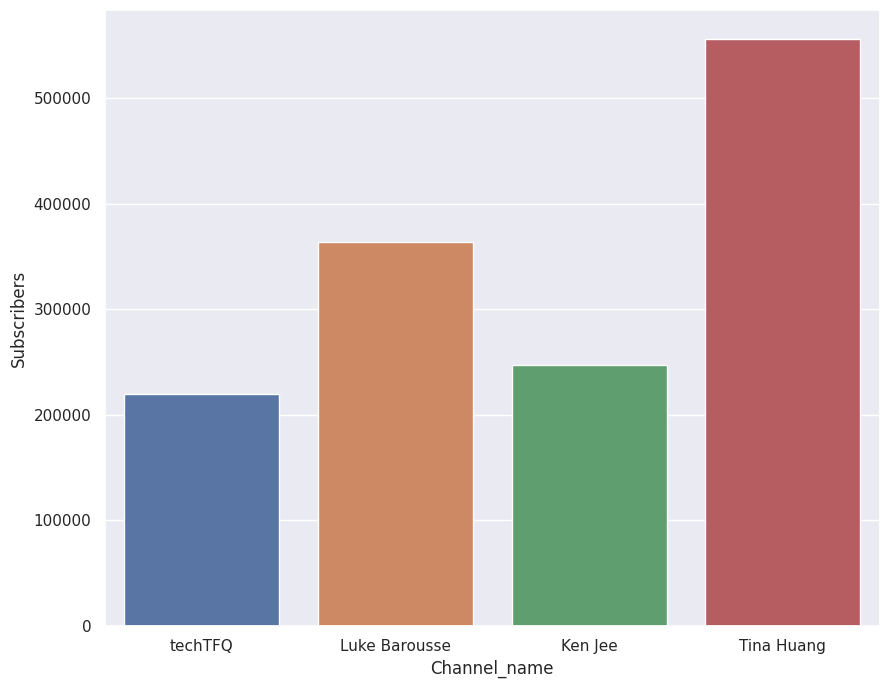

In [9]:
sns.set(rc={'figure.figsize': (10,8)})
ax = sns.barplot(x='Channel_name', y='Subscribers', data=channel_data)

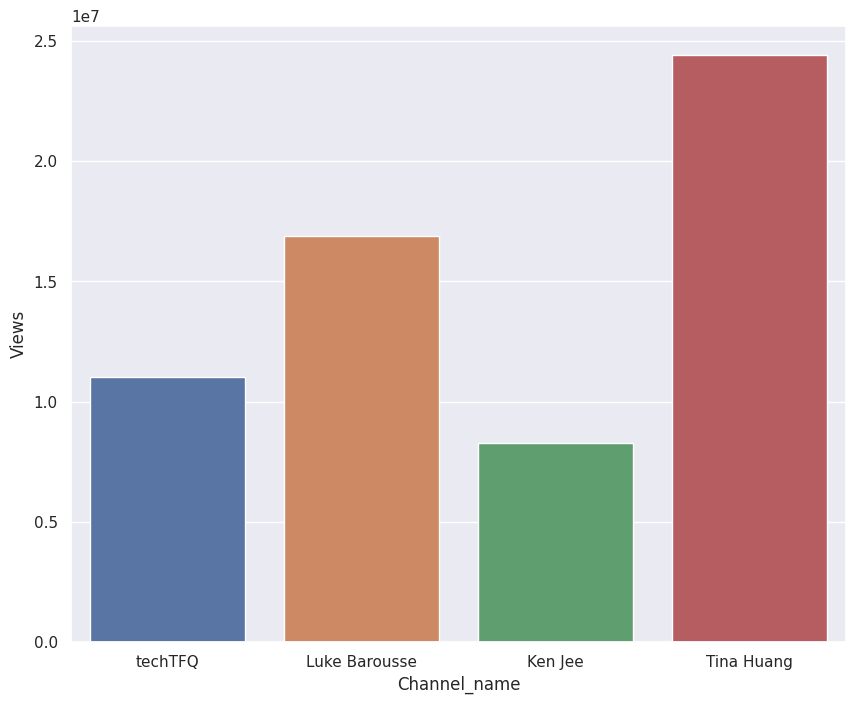

In [10]:
ax = sns.barplot(x='Channel_name', y='Views', data=channel_data)

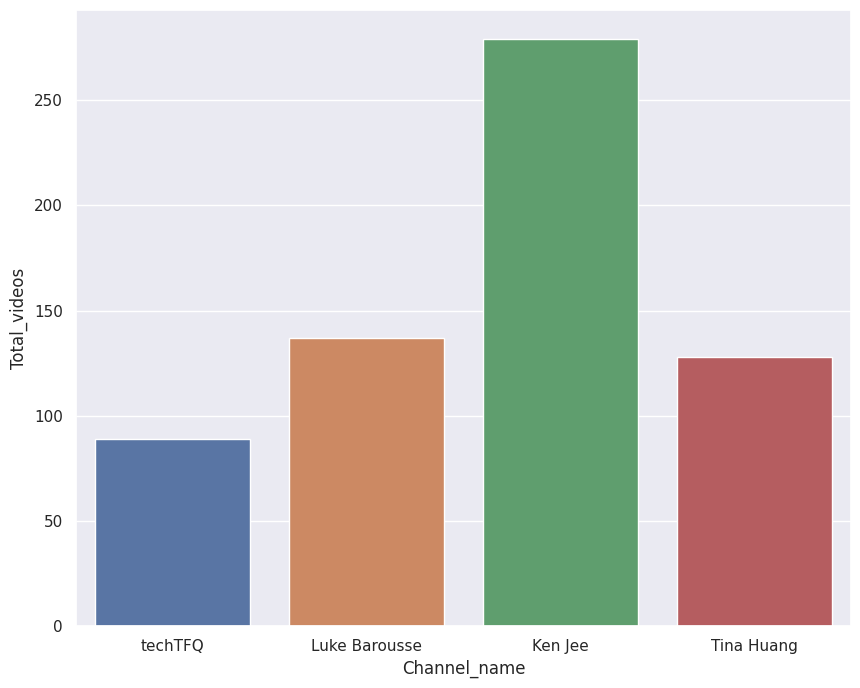

In [11]:
ax = sns.barplot(x='Channel_name', y='Total_videos', data=channel_data)

## Function to get video ids

In [12]:
playlist_id = channel_data.loc[channel_data['Channel_name'] == 'Ken Jee', 'playlist_id'].iloc[0]

In [13]:
playlist_id

'UUiT9RITQ9PW6BhXK0y2jaeg'

In [14]:
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
        more_pages = True
    while more_pages:
            if next_page_token is None:
                more_pages = False
            else:
                request = youtube.playlistItems().list(
                     part = 'contentDetails',
                     playlistId = playlist_id,
                     maxResults = 50,
                     pageToken = next_page_token)
                response = request.execute()
                
                for i in range(len(response['items'])):
                   video_ids.append(response['items'][i]['contentDetails']['videoId'])
                next_page_token = response.get('nextPageToken')
    return video_ids

In [15]:
video_ids = get_video_ids(youtube, playlist_id)

## Functionto get video details

In [16]:
def get_video_details(youtube, video_ids):
    all_video_stats = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet, statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        for video in response['items']:
            video_stats = {
                'Title': video['snippet']['title'],
                'Published_date': video['snippet']['publishedAt'],
                'Views': video['statistics']['viewCount'],
                'Likes': video['statistics']['likeCount'],
                'Comments': video['statistics']['commentCount']
            }
            all_video_stats.append(video_stats)
    return all_video_stats

In [17]:
video_details = get_video_details(youtube, video_ids)

In [18]:
video_data = pd.DataFrame(video_details)

In [19]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date

In [20]:
video_data['Views']  = pd.to_numeric(video_data['Views'])
video_data['Likes']  = pd.to_numeric(video_data['Likes'])
video_data['Comments']  = pd.to_numeric(video_data['Comments'])

In [21]:
video_data

,Title,Published_date,Views,Likes,Comments
0,7 Enticing Jobs AI Will Create,2023-07-24,2975,142,30
1,The ChatGPT Code Interpreter is OVERRATED,2023-07-22,3120,115,26
2,Exciting Announcement!,2023-06-23,6165,282,48
3,AI: A Customer Service Revolution?,2023-05-26,3355,114,35
4,Beginner Kaggle Data Science Project Walk-Thro...,2023-05-16,16827,644,54
...,...,...,...,...,...
274,How to Simulate NBA Games in Python,2018-11-19,17555,391,54
275,Should You Get A Masters in Data Science?,2018-11-14,20490,306,135
276,How I Became A Data Scientist From a Business ...,2018-11-12,6408,198,23
277,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,8605,193,17


In [22]:
top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)

In [23]:
top10_videos

,Title,Published_date,Views,Likes,Comments
181,How I Would Learn Data Science (If I Had to St...,2020-05-08,1390960,49004,1997
202,The Best Free Data Science Courses Nobody is T...,2020-03-09,343298,21114,620
61,How I Would Learn Data Science in 2022 (If I H...,2021-12-27,337485,14900,536
208,3 Proven Data Science Projects for Beginners (...,2020-02-17,322135,17642,523
157,Beginner Kaggle Data Science Project Walk-Thro...,2020-07-17,316729,7100,419
194,Data Science Project from Scratch - Part 1 (Pr...,2020-04-03,183674,4760,170
247,The Projects You Should Do To Get A Data Scien...,2019-07-30,149326,5688,254
94,Why You Probably Won't Become a Data Scientist,2021-04-09,136916,4016,480
109,How I Would Learn Data Science in 2021 (What H...,2020-12-19,131273,5974,488
178,How to Make A Data Science Portfolio Website w...,2020-05-15,124272,4267,192


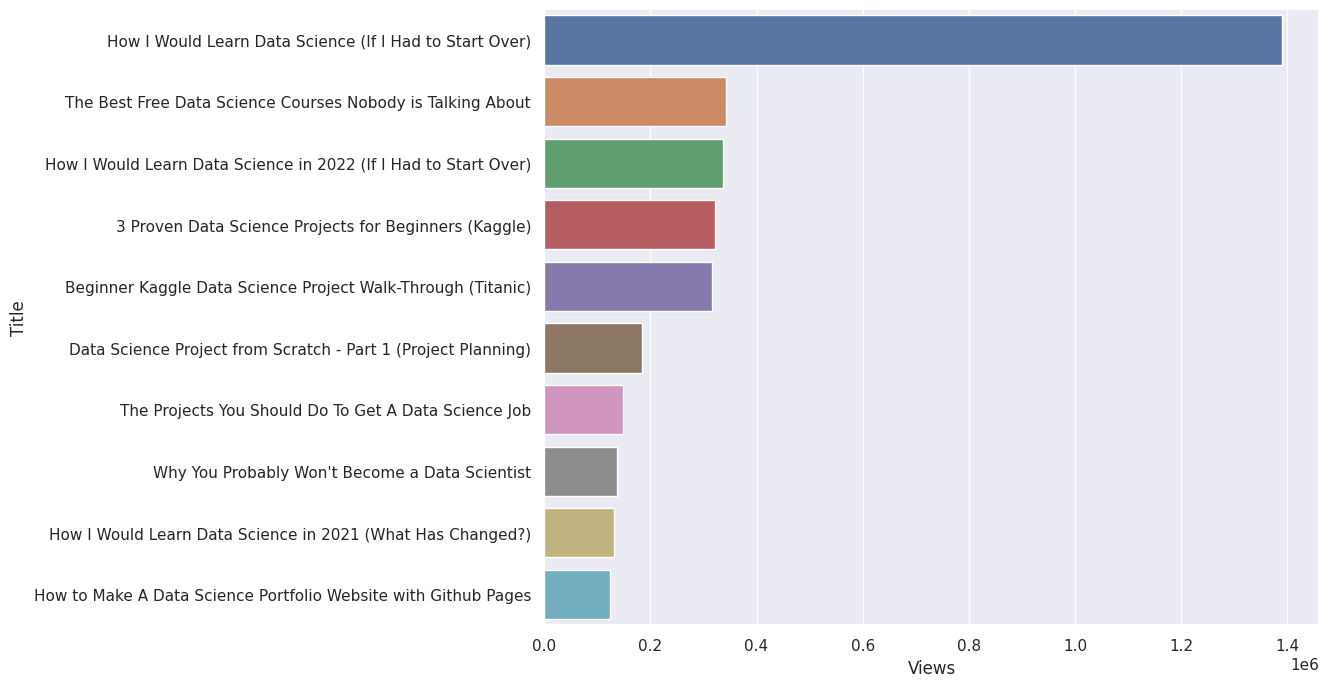

In [24]:
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

In [25]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [26]:
video_data

,Title,Published_date,Views,Likes,Comments,Month
0,7 Enticing Jobs AI Will Create,2023-07-24,2975,142,30,Jul
1,The ChatGPT Code Interpreter is OVERRATED,2023-07-22,3120,115,26,Jul
2,Exciting Announcement!,2023-06-23,6165,282,48,Jun
3,AI: A Customer Service Revolution?,2023-05-26,3355,114,35,May
4,Beginner Kaggle Data Science Project Walk-Thro...,2023-05-16,16827,644,54,May
...,...,...,...,...,...,...
274,How to Simulate NBA Games in Python,2018-11-19,17555,391,54,Nov
275,Should You Get A Masters in Data Science?,2018-11-14,20490,306,135,Nov
276,How I Became A Data Scientist From a Business ...,2018-11-12,6408,198,23,Nov
277,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,8605,193,17,Jul


In [27]:
videos_per_month = video_data.groupby('Month', as_index=False).size()

In [28]:
videos_per_month

,Month,size
0,Apr,22
1,Aug,24
2,Dec,20
3,Feb,25
4,Jan,29
5,Jul,27
6,Jun,20
7,Mar,32
8,May,24
9,Nov,20


In [29]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [30]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

In [31]:
videos_per_month = videos_per_month.sort_index()

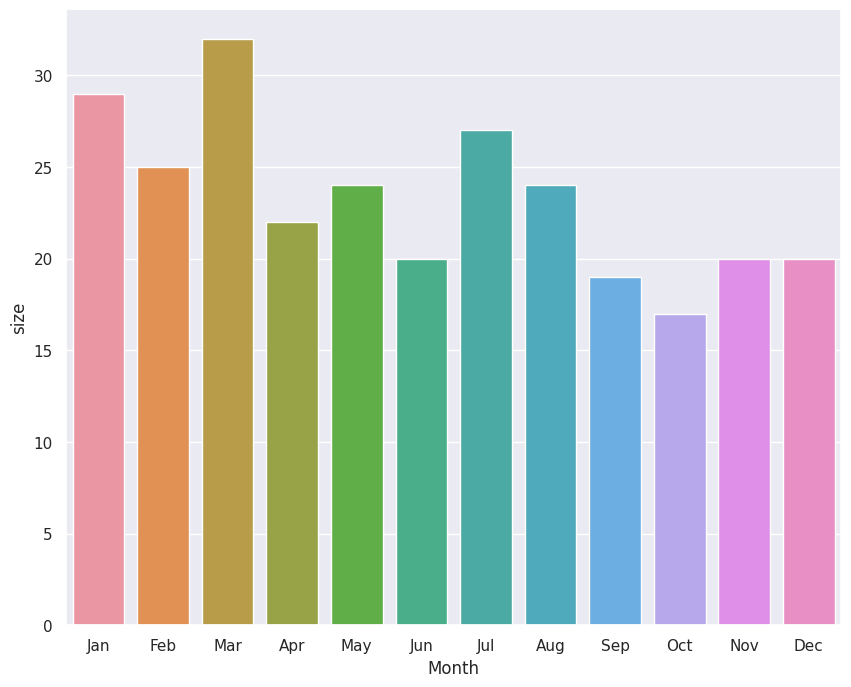

In [32]:
ax2 = sns.barplot(x='Month', y='size', data=videos_per_month )

In [33]:
video_data.to_csv('Video_Details.csv')